In [1]:
import gc
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

### Load data

In [2]:
# Load CSV
df = pd.read_csv('../data/cleaned_for_eda.csv')
print(f"Loaded {len(df):,} rows\n")

Loaded 38,074,228 rows



# Exploratory Data Analysis

In [3]:
# Text length distribution
text_length = df['text'].fillna('').str.len()
word_count = df['text'].fillna('').str.split().str.len()
print("Text Length Statistics:")
text_dist_table = pd.DataFrame({'text_length': text_length,
                                'word_count': word_count
                               }).describe().round(2)
print(text_dist_table)
print()

# Reviews per business
print("Reviews per Business:")
business_counts = df['gmap_id'].value_counts()
print(business_counts.describe().round(2))
print()

# Reviews per user
print("Reviews per User:")
user_counts = df['user_id'].value_counts()
print(user_counts.describe().round(2))
print()

#del rating_dist, rating_dist_table, text_length, word_count, business_counts, user_counts, text_dist_table
#gc.collect()

Text Length Statistics:
       text_length   word_count
count  38074228.00  38074228.00
mean        146.63        26.67
std         221.06        41.25
min           0.00         0.00
25%          34.00         6.00
50%          76.00        13.00
75%         172.00        31.00
max       13057.00      1840.00

Reviews per Business:
count    504404.00
mean         75.48
std         197.63
min           1.00
25%           7.00
50%          20.00
75%          67.00
max        9998.00
Name: count, dtype: float64

Reviews per User:
count    9944619.00
mean           3.83
std           11.55
min            1.00
25%            1.00
50%            1.00
75%            2.00
max         1477.00
Name: count, dtype: float64



### Text characteristics

In [4]:
# Average text/word length by rating
print("Text Characteristics by Rating:")
text_stats = pd.DataFrame({'avg_text_length': df.groupby('rating')['text'].apply(lambda x: x.fillna('').str.len().mean()),
                           'avg_word_count': df.groupby('rating')['text'].apply(lambda x: x.fillna('').str.split().str.len().mean())
                          }).round(2)
print(text_stats)

#del text_stats
#gc.collect()

Text Characteristics by Rating:
        avg_text_length  avg_word_count
rating                                 
1.0              307.52           57.89
2.0              228.78           42.75
3.0              147.75           27.35
4.0              119.42           21.62
5.0              127.20           22.78


### Category analysis

Categories:

Total unique categories: 86,882
Total reviews: 38,074,228

Average Rating by Category (Top 20):
                                                    mean    count
category                                                         
['Mexican restaurant']                              4.26  872,784
['Shopping mall']                                   4.28  783,112
['Hotel']                                           4.07  591,775
['Park', 'Tourist attraction']                      4.50  569,660
['Fast food restaurant', 'Breakfast restaurant'...  3.39  537,137
['Restaurant']                                      4.31  436,777
['Coffee shop', 'Breakfast restaurant', 'Cafe',...  3.99  341,586
['Fast food restaurant', 'Breakfast restaurant'...  3.74  268,329
['Mexican restaurant', 'Restaurant']                4.28  254,216
['Diner', 'American restaurant', 'Breakfast res...  3.81  222,512
['Hamburger restaurant', 'American restaurant',...  4.56  208,652
['Grocery store']                

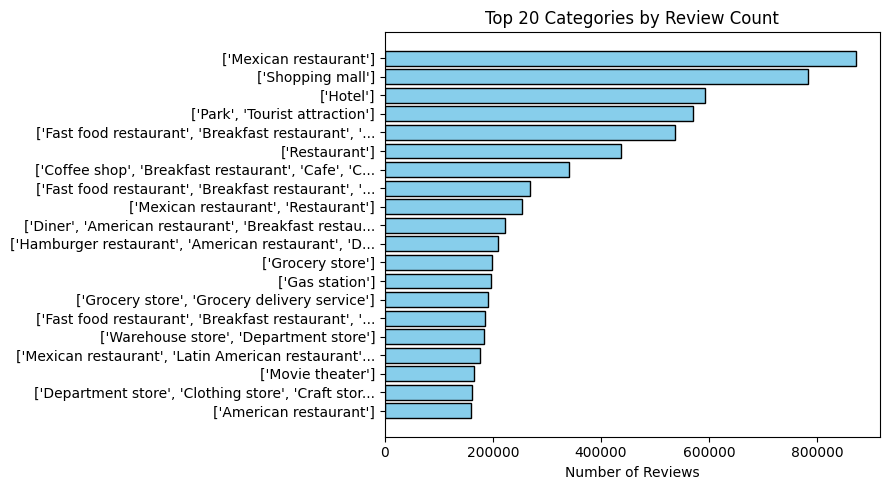

In [5]:
print("Categories:")
category_counts = df['category'].value_counts()

print(f"\nTotal unique categories: {len(category_counts):,}")
print(f"Total reviews: {len(df):,}\n")

# Average rating by category (top 20)
print("Average Rating by Category (Top 20):")
cat_ratings = df.groupby('category')['rating'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20).round(2)
cat_ratings['count'] = cat_ratings['count'].astype(int).apply(lambda x: f'{x:,}')
print(cat_ratings)
print()

# Top 20 Categories
cat_counts = category_counts.head(20)
cat_labels = [str(c)[:50] + '...' if len(str(c)) > 50 else str(c) for c in cat_counts.index]

plt.figure(figsize=(9, 5))
plt.barh(range(len(cat_counts)), cat_counts.values, color='skyblue', edgecolor='black')
plt.yticks(range(len(cat_counts)), cat_labels)
plt.xlabel('Number of Reviews')
plt.title('Top 20 Categories by Review Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#del cat_counts, cat_labels, cat_ratings, category_counts
#gc.collect()

### Review Analysis

In [6]:
# Reviews by year
df_time = pd.to_datetime(df['time'], unit='ms')
print("Reviews by Year:")
year_counts = df_time.dt.year.value_counts().sort_index()
year_counts.index = year_counts.index.astype(int)
year_counts_display = year_counts.apply(lambda x: f'{x:,}')
print(year_counts_display)
print()

# Average rating by year
rating_by_year = df.groupby(df_time.dt.year)['rating'].mean().round(2)
print("Average Rating by Year:")
print(rating_by_year)

#del year_counts_display, rating_by_year
#gc.collect()

Reviews by Year:
time
1990           183
1999             2
2002             4
2003            34
2004           242
2005           450
2006           538
2007           789
2008         1,513
2009         2,726
2010        13,838
2011        31,653
2012        93,475
2013       204,149
2014       301,824
2015       642,787
2016     2,202,538
2017     5,492,579
2018     8,800,607
2019    10,362,009
2020     6,769,864
2021     3,152,424
Name: count, dtype: str

Average Rating by Year:
time
1990    4.14
1999    4.50
2002    4.25
2003    3.82
2004    3.93
2005    3.86
2006    3.98
2007    3.87
2008    3.79
2009    3.71
2010    3.91
2011    3.93
2012    4.13
2013    4.07
2014    4.07
2015    4.03
2016    4.11
2017    4.18
2018    4.23
2019    4.27
2020    4.28
2021    4.31
Name: rating, dtype: float64


### Correlation analysis

Correlation Matrix:
             rating  avg_rating  text_length  word_count
rating         1.00        0.38        -0.22       -0.23
avg_rating     0.38        1.00        -0.03       -0.03
text_length   -0.22       -0.03         1.00        1.00
word_count    -0.23       -0.03         1.00        1.00



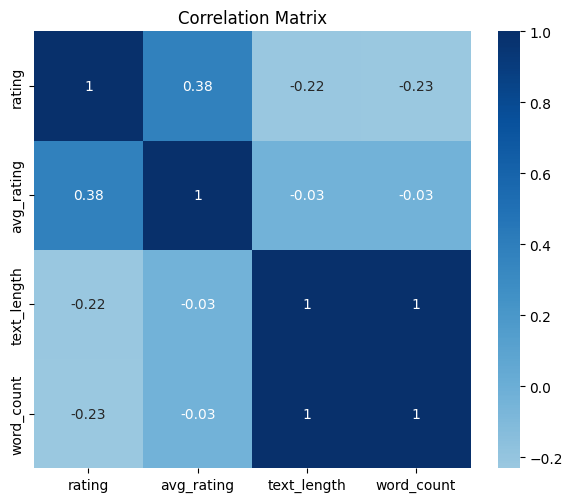

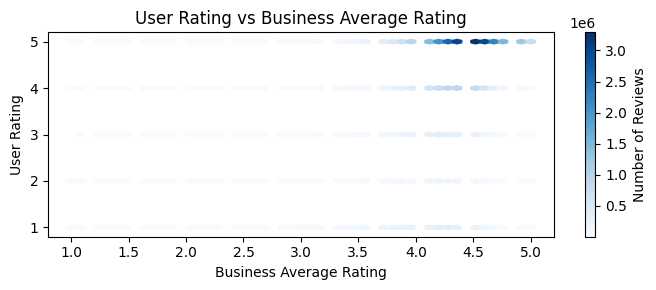

In [7]:
print("Correlation Matrix:")
numeric_features = df[['rating', 'avg_rating']].copy()
numeric_features['text_length'] = df['text'].fillna('').str.len()
numeric_features['word_count'] = df['text'].fillna('').str.split().str.len()

corr_matrix = numeric_features.corr().round(2)
print(corr_matrix)
print()

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Scatter plot: User rating vs Business avg_rating
plt.figure(figsize=(7, 3))
plt.hexbin(df['avg_rating'], df['rating'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Reviews')
plt.xlabel('Business Average Rating')
plt.ylabel('User Rating')
plt.title('User Rating vs Business Average Rating')
plt.tight_layout()
plt.show()

#del numeric_features, corr_matrix
#gc.collect()

### Outlier Analysis

Text Length Outliers:
Reviews with 1000+ characters: 417,518 (1.10%)
Reviews with 2000+ characters: 66,849 (0.18%)
Reviews with 5000+ characters: 235 (0.00%)

Business Review Count Outliers:
Businesses with 1000+ reviews: 2,920
Businesses with 5000+ reviews: 86
Max reviews for one business: 9,998

User Review Count Outliers:
Users with 100+ reviews: 24,938
Users with 500+ reviews: 199
Max reviews by one user: 1,477

Timestamp Outliers:
Reviews before 2010: 6,481 (0.02%)
Reviews after 2021: 0 (0.00%)



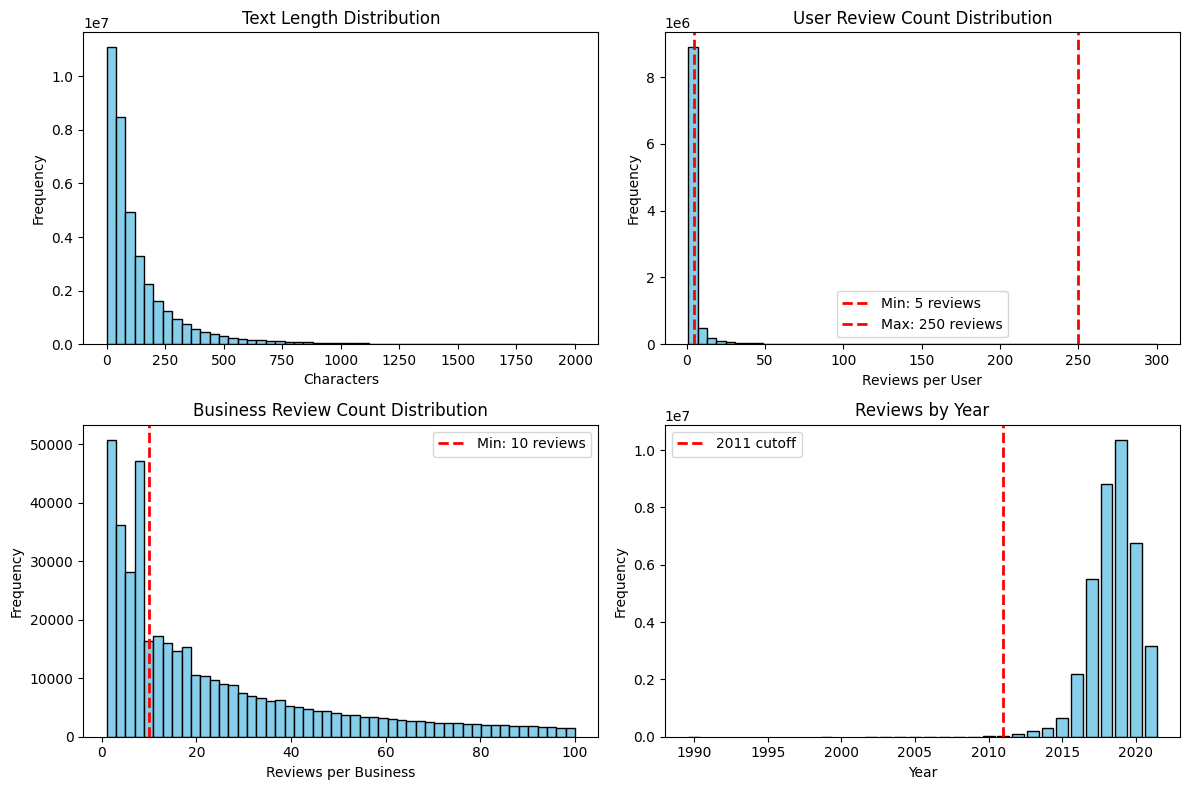

In [8]:
# Text length outliers
text_length = df['text'].fillna('').str.len()
word_count = df['text'].fillna('').str.split().str.len()

print("Text Length Outliers:")
print(f"Reviews with 1000+ characters: {(text_length > 1000).sum():,} ({(text_length > 1000).sum()/len(df)*100:.2f}%)")
print(f"Reviews with 2000+ characters: {(text_length > 2000).sum():,} ({(text_length > 2000).sum()/len(df)*100:.2f}%)")
print(f"Reviews with 5000+ characters: {(text_length > 5000).sum():,} ({(text_length > 5000).sum()/len(df)*100:.2f}%)")
print()

# Business review count outliers
business_counts = df['gmap_id'].value_counts()
print("Business Review Count Outliers:")
print(f"Businesses with 1000+ reviews: {(business_counts >= 1000).sum():,}")
print(f"Businesses with 5000+ reviews: {(business_counts >= 5000).sum():,}")
print(f"Max reviews for one business: {business_counts.max():,}")
print()

# User review count outliers
user_counts = df['user_id'].value_counts()
print("User Review Count Outliers:")
print(f"Users with 100+ reviews: {(user_counts >= 100).sum():,}")
print(f"Users with 500+ reviews: {(user_counts >= 500).sum():,}")
print(f"Max reviews by one user: {user_counts.max():,}")
print()

# Unusual timestamps
print("Timestamp Outliers:")
print(f"Reviews before 2010: {(df_time.dt.year < 2010).sum():,} ({(df_time.dt.year < 2010).sum()/len(df)*100:.2f}%)")
print(f"Reviews after 2021: {(df_time.dt.year > 2021).sum():,} ({(df_time.dt.year > 2021).sum()/len(df)*100:.2f}%)")
print()

# Visualize outlier distributions with thresholds
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Text length - no cutoff lines (we don't filter by text length)
axes[0,0].hist(text_length[text_length <= 2000], bins=50, color='skyblue', edgecolor='black')
axes[0,0].set_title('Text Length Distribution')
axes[0,0].set_xlabel('Characters')
axes[0,0].set_ylabel('Frequency')

# User counts
axes[0,1].hist(user_counts[user_counts <= 300], bins=50, color='skyblue', edgecolor='black')
axes[0,1].axvline(5, color='red', linestyle='--', linewidth=2, label='Min: 5 reviews')
axes[0,1].axvline(250, color='red', linestyle='--', linewidth=2, label='Max: 250 reviews')
axes[0,1].set_title('User Review Count Distribution')
axes[0,1].set_xlabel('Reviews per User')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Business counts
axes[1,0].hist(business_counts[business_counts <= 100], bins=50, color='skyblue', edgecolor='black')
axes[1,0].axvline(10, color='red', linestyle='--', linewidth=2, label='Min: 10 reviews')
axes[1,0].set_title('Business Review Count Distribution')
axes[1,0].set_xlabel('Reviews per Business')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Year distribution
year_counts_hist = df_time.dt.year.value_counts().sort_index()
axes[1,1].bar(year_counts_hist.index, year_counts_hist.values, color='skyblue', edgecolor='black')
axes[1,1].axvline(2011, color='red', linestyle='--', linewidth=2, label='2011 cutoff')
axes[1,1].set_title('Reviews by Year')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

#del text_length, word_count, business_counts, user_counts, year_counts_hist
#gc.collect()

### Rating distribution

Rating Distribution:

Class Imbalance Chart:
           Count  Percentage
rating                      
1.0      3314230        8.70
2.0      1340273        3.52
3.0      2699038        7.09
4.0      6366070       16.72
5.0     24354617       63.97


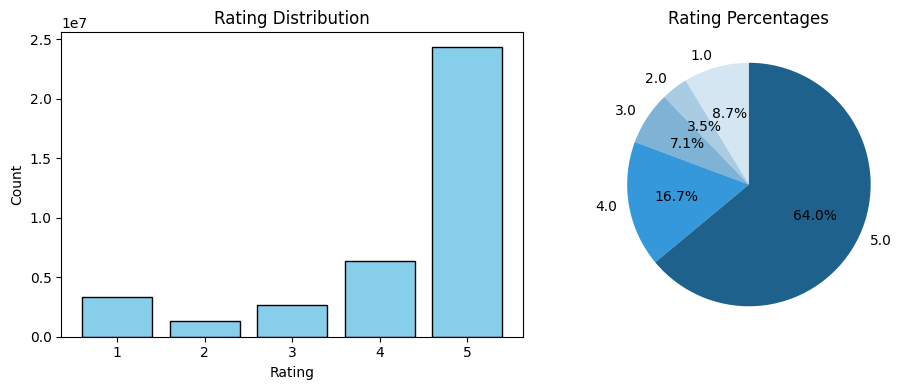


Imbalance ratio (5-star / 2-star): 18.2:1


In [9]:
# Rating distribution
print("Rating Distribution:")
rating_dist = df['rating'].value_counts().sort_index()
rating_dist_table = pd.DataFrame({'Count': rating_dist,
                                  'Percentage': (rating_dist / len(df) * 100).round(2)
                                 })
print()
print("Class Imbalance Chart:")
print(rating_dist_table)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar(rating_dist.index, rating_dist.values, color='skyblue', edgecolor='black')
ax1.set_title('Rating Distribution')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

ax2.pie(rating_dist.values, labels=rating_dist.index, autopct='%1.1f%%', startangle=90, colors=['#d4e6f1', '#a9cce3', '#7fb3d5', '#3498db', '#1f618d'])
ax2.set_title('Rating Percentages')

plt.tight_layout()
plt.show()

print(f"\nImbalance ratio (5-star / 2-star): {rating_dist[5.0] / rating_dist[2.0]:.1f}:1")

#del rating_dist
#gc.collect()

### Detailed user/review distributions

In [10]:
# Review distributions 
user_review_counts = df['user_id'].value_counts()
business_review_counts = df['gmap_id'].value_counts()

print("Reviewer Distributions:")

# Thresholds for reviewers
reviewer_thresholds = [1, 2, 3, 5, 10, 25, 50, 100, 250, 500]

print(f"\n{'Min Reviews':<15} {'Users':<15} {'% of Users':<15} {'Total Reviews':<15} {'% of Reviews':<15}")
print("-" * 75)

for threshold in reviewer_thresholds:
    users_above = (user_review_counts >= threshold).sum()
    pct_users = (users_above / len(user_review_counts)) * 100
    
    reviews_from_these_users = user_review_counts[user_review_counts >= threshold].sum()
    pct_reviews = (reviews_from_these_users / len(df)) * 100
    
    print(f"{threshold}+ reviews{'':<5} {users_above:<15,} {pct_users:<15.2f} {reviews_from_these_users:<15,} {pct_reviews:<15.2f}")

print()
print("Business Review Distributions:")

# Thresholds for businesses
business_thresholds = [1, 3, 5, 10, 25, 50, 100, 500, 1000]

print(f"\n{'Min Reviews':<15} {'Businesses':<15} {'% of Businesses':<15} {'Total Reviews':<15} {'% of Reviews':<15}")
print("-" * 75)

for threshold in business_thresholds:
    businesses_above = (business_review_counts >= threshold).sum()
    pct_businesses = (businesses_above / len(business_review_counts)) * 100
    
    reviews_from_these_biz = business_review_counts[business_review_counts >= threshold].sum()
    pct_reviews = (reviews_from_these_biz / len(df)) * 100
    
    print(f"{threshold}+ reviews{'':<5} {businesses_above:<15,} {pct_businesses:<15.2f} {reviews_from_these_biz:<15,} {pct_reviews:<15.2f}")

#del user_review_counts, business_review_counts
#gc.collect()

Reviewer Distributions:

Min Reviews     Users           % of Users      Total Reviews   % of Reviews   
---------------------------------------------------------------------------
1+ reviews      9,944,619       100.00          38,074,228      100.00         
2+ reviews      3,823,158       38.44           31,952,767      83.92          
3+ reviews      2,405,238       24.19           29,116,927      76.47          
5+ reviews      1,444,280       14.52           25,883,160      67.98          
10+ reviews      733,591         7.38            21,272,989      55.87          
25+ reviews      257,680         2.59            14,165,213      37.20          
50+ reviews      93,253          0.94            8,584,575       22.55          
100+ reviews      24,938          0.25            3,979,394       10.45          
250+ reviews      2,295           0.02            794,189         2.09           
500+ reviews      199             0.00            128,048         0.34           

Business 

### Lanaguage analysis

In [11]:
# Check for non-English reviews
def is_likely_english(text):
    """Fast heuristic: >80% ASCII characters = likely English."""
    if pd.isna(text) or len(str(text).strip()) == 0:
        return False
    text = str(text)
    ascii_count = sum(1 for c in text if ord(c) < 128)
    return (ascii_count / len(text)) > 0.8

print("Language Distribution:")
print()
df['is_english'] = df['text'].apply(is_likely_english)
df['has_original_tag'] = df['text'].str.contains(r'\(Original\)', na=False)

print(f"English reviews: {df['is_english'].sum():,} ({df['is_english'].sum()/len(df)*100:.2f}%)")
print(f"Non-English reviews: {(~df['is_english']).sum():,} ({(~df['is_english']).sum()/len(df)*100:.2f}%)")
print(f"Reviews with (Original) tag: {df['has_original_tag'].sum():,} ({df['has_original_tag'].sum()/len(df)*100:.2f}%)")

#del df['is_english'], df['has_original_tag'], df_time
#gc.collect()

Language Distribution:

English reviews: 37,902,484 (99.55%)
Non-English reviews: 171,744 (0.45%)
Reviews with (Original) tag: 2,265,777 (5.95%)


**EDA Takeaways:**

- Reviews are heavily skewed positive (64% are 5-stars)
- Negative reviews (1-2 stars) are longer than positive ones, likely people write more when they're upset
- Big increase in reviews from 2016-2019, in 2020 COVID is likely the cause of drop and 2021 is incomplete
- Most users are one-time reviewers (median = 1 review)
- Heavy users are the bulk of reviews with 15% of users writing 68% of all reviews
- Fast food chains generally get lower ratings (3.4-3.7) compared to sit-down restaurants, parks and malls (4.2-4.5)
- Users tend to rate slightly higher than business averages (0.38 correlation)
- Long reviews and heavy users are rare - only 0.18% of reviews are extremely long (2000+ chars) and heavy active users (500+ reviews) are less than 200
- Google business reviews launched in 2007, added picture support in 2016, and surpassed Facebook as largest consumer review platform in 2017
- Dataset is 99.5% English, but 6% contain Google's "(Original)" auto-translation tag indicating non-English source text which may have translation quality issues
- Text length negatively correlates with rating (-0.22) - *dissatisfied customers write more detailed reviews*

## Aspect and keyword eda

In [12]:
def get_top_words(df, rating_filter=None, n=50):
    """Get top words from reviews, optionally filtered by rating."""
    if rating_filter:
        texts = df[df['rating'].isin(rating_filter)]['text'].fillna('')
    else:
        texts = df['text'].fillna('')
    
    # Basic stopwords
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
                 'for', 'of', 'with', 'is', 'was', 'are', 'were', 'it', 'this',
                 'that', 'they', 'we', 'i', 'my', 'our', 'their', 'be', 'been',
                 'have', 'had', 'has', 'not', 'no', 'so', 'if', 'as', 'by',
                 'from', 'up', 'out', 'very', 'just', 'get', 'got', 'go', 'went'}
    
    words = []
    for text in texts:
        tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
        words.extend([w for w in tokens if w not in stopwords])
    
    return Counter(words).most_common(n)

# Top words overall
print("Top 50 words overall:")
print(get_top_words(df, n=50))
print()

# Top words in negative reviews (1-2 stars)
print("Top 50 words in negative reviews:")
print(get_top_words(df, rating_filter=[1.0, 2.0], n=50))
print()

# Top words in neutral reviews (3 stars)
print("Top 50 words in neutral reviews:")
print(get_top_words(df, rating_filter=[3.0], n=50))
print()

# Top words in positive reviews (4-5 stars)
print("Top 50 words in positive reviews:")
print(get_top_words(df, rating_filter=[4.0, 5.0], n=50))

Top 50 words overall:
[('great', 10238167), ('good', 8528704), ('you', 8199793), ('food', 7610876), ('service', 7312534), ('place', 6608096), ('there', 4252191), ('all', 3724508), ('nice', 3559413), ('here', 3443662), ('staff', 3405817), ('time', 3376350), ('friendly', 3252446), ('best', 3156125), ('always', 3011559), ('love', 2837228), ('like', 2746857), ('one', 2580655), ('can', 2475105), ('when', 2467230), ('will', 2420416), ('your', 2353570), ('original', 2352800), ('google', 2337879), ('back', 2301225), ('translated', 2266638), ('would', 2255933), ('really', 2218929), ('what', 2146160), ('clean', 1936477), ('them', 1930580), ('people', 1907783), ('she', 1891252), ('customer', 1886330), ('recommend', 1834080), ('about', 1798528), ('amazing', 1766203), ('well', 1734819), ('only', 1716501), ('experience', 1692380), ('excellent', 1687310), ('more', 1680299), ('even', 1570601), ('also', 1558750), ('delicious', 1548404), ('store', 1511933), ('helpful', 1493239), ('car', 1489064), ('some

In [13]:
# Sample 1 million of each rating for speed
sample = df.groupby('rating').sample(n=1000000, random_state=42)

vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2)) # unigram and bigram pairs
tfidf = vectorizer.fit_transform(sample['text'].fillna(''))
feature_names = vectorizer.get_feature_names_out()

# Mean TF-IDF score per rating per word
print("Most distinctive words by rating:")
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    mask = (sample['rating'] == rating).values
    mean_tfidf = tfidf[mask].mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-20:][::-1]
    top_words = [(feature_names[i], round(mean_tfidf[i], 4)) for i in top_indices]
    print(f"\nRating {rating}:")
    print(top_words)

Most distinctive words by rating:

Rating 1.0:
[('service', np.float64(0.0454)), ('food', np.float64(0.0324)), ('place', np.float64(0.0323)), ('bad', np.float64(0.0314)), ('rude', np.float64(0.0303)), ('don', np.float64(0.0301)), ('time', np.float64(0.0291)), ('just', np.float64(0.0268)), ('customer', np.float64(0.0264)), ('worst', np.float64(0.0258)), ('like', np.float64(0.0252)), ('horrible', np.float64(0.025)), ('order', np.float64(0.0249)), ('people', np.float64(0.0221)), ('customer service', np.float64(0.0212)), ('got', np.float64(0.0208)), ('told', np.float64(0.0206)), ('said', np.float64(0.0205)), ('didn', np.float64(0.0193)), ('car', np.float64(0.019))]

Rating 2.0:
[('food', np.float64(0.0507)), ('service', np.float64(0.0376)), ('good', np.float64(0.0352)), ('like', np.float64(0.0284)), ('place', np.float64(0.0262)), ('just', np.float64(0.0256)), ('time', np.float64(0.0237)), ('order', np.float64(0.0213)), ('ok', np.float64(0.02)), ('don', np.float64(0.0199)), ('bad', np.float

## Keyword Frequency Takeaways

### Top 50 Words Overall
The most frequent words across all 38M reviews are largely **generic sentiment words** (`great`, `good`, `nice`, `amazing`) and **aspect identifiers** (`food`, `service`, `staff`, `place`, `clean`). These high-frequency words appear across all ratings and business types, meaning they identify **what** a review is about but carry limited discriminative power on their own.

Notable noise in the text:
- `original`, `google`, `translated` appear in top 50 - these are translation artifacts from Google's auto-translation tag and should be removed from any text analysis
- `car` appearing in top 50 reflects the presence of auto-related businesses (gas stations, dealerships) in the dataset alongside restaurants

### Word Frequency by Rating

**Negative reviews (1-2 stars)** are characterized by narrative complaint words - `told`, `said`, `asked`, `never`, `didn` suggest customers are recounting specific negative interactions. Aspect words `service` and `order` dominate, indicating service failures and order issues are the primary drivers of negative reviews. Sentiment words are strongly negative: `bad`, `rude`, `worst`, `horrible`.

**Neutral reviews (3 stars)** show hedging language - `ok`, `okay`, `better`, `little`, `pretty` are distinctive. This is consistent with 3-star reviews expressing mixed or tempered opinions. `parking` and `prices` appearing here suggests these are common sources of mild dissatisfaction that don't tank the overall rating.

**Positive reviews (4-5 stars)** are dominated by strong sentiment words: 4-star uses `nice`, `friendly`, `clean`, `fast` suggesting specific positive aspects, while 5-star skews toward superlatives: `best`, `amazing`, `excellent`, `awesome`, `delicious`, `helpful`. The distinction between 4 and 5 star word choice suggests 5-star reviews are more emotionally driven while 4-star reviews are more descriptively positive.

### Key Takeaways for Aspect Modeling

1. **Aspect keywords are rating-agnostic** - `food`, `service`, `place`, `staff` appear across all ratings. They identify the subject of the review, not the sentiment. This confirms the need for separate aspect detection and sentiment classification in ABSA.

2. **Sentiment keywords are rating-specific** - `rude`, `worst`, `horrible` skew negative; `amazing`, `excellent`, `delicious` skew positive. These will likely form the basis of sentiment labeling within each aspect.

3. **Translation artifacts must be filtered** - `original`, `google`, `translated` are corpus noise from Google's auto-translation system and should be excluded from text. 

4. **Service is the most discriminative aspect** - it appears prominently across all ratings but with very different associated words (negative: `rude`, `customer service`; positive: `friendly`, `helpful`). This makes it the strongest candidate for ABSA.

5. **Dataset scope affects aspect design** - with 86,882 unique category combinations spanning restaurants, retail, hotels, parks and more, aspect keywords need to be general enough to apply across business types.

Aspect Mention Frequency:
FOOD_QUALITY      16,723,790 mentions |   11,784,126 reviews (30.95%)
SERVICE           19,396,941 mentions |   13,250,320 reviews (34.80%)
WAIT_TIME          9,490,367 mentions |    6,797,427 reviews (17.85%)
PRICE_VALUE        8,702,211 mentions |    5,726,385 reviews (15.04%)
CLEANLINESS        2,780,379 mentions |    2,609,475 reviews ( 6.85%)
ATMOSPHERE         4,186,940 mentions |    3,663,221 reviews ( 9.62%)

Average Aspect Mentions by Rating:
        food_quality_mentions  service_mentions  wait_time_mentions  \
rating                                                                
1.0                      0.48              0.92                0.55   
2.0                      0.63              0.63                0.47   
3.0                      0.51              0.40                0.32   
4.0                      0.50              0.39                0.25   
5.0                      0.40              0.49                0.19   

        price_value_

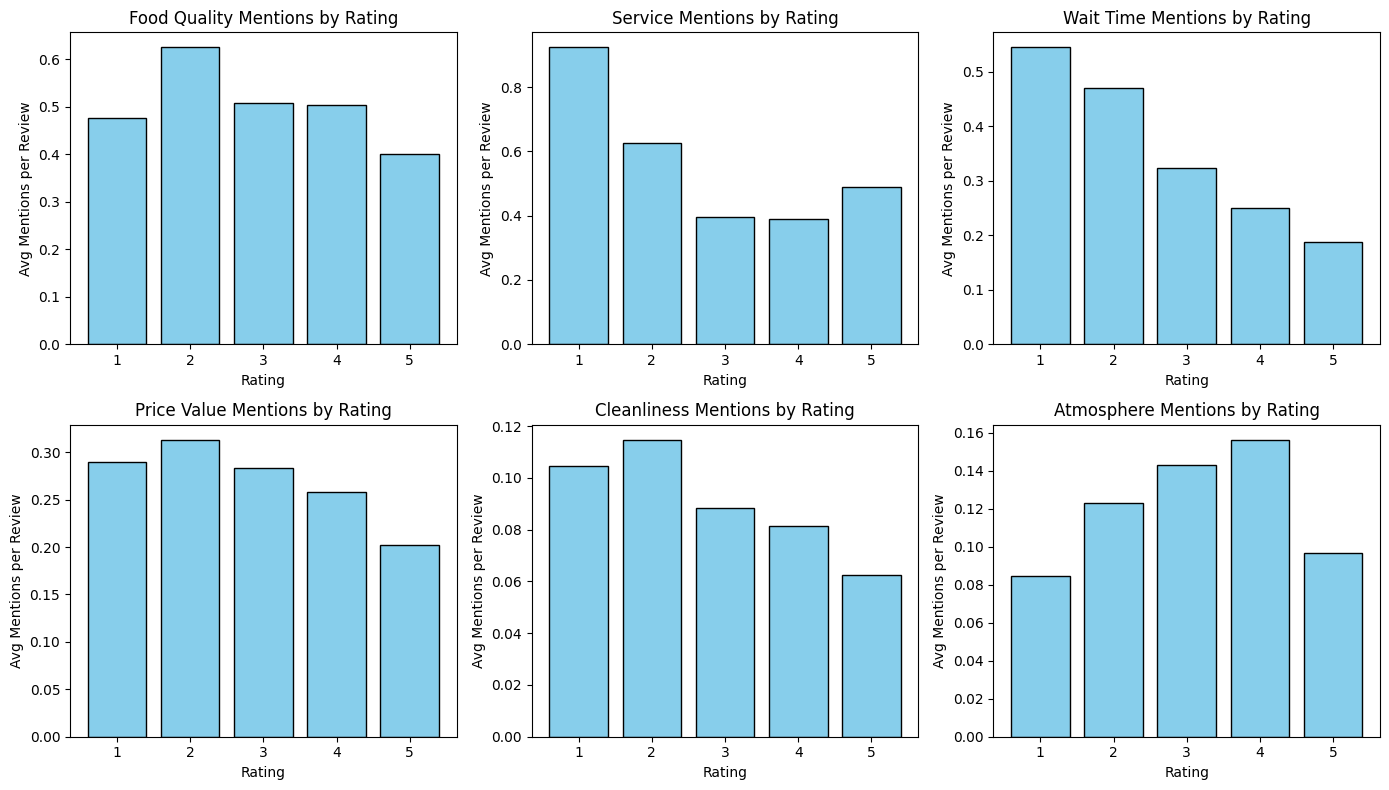

In [14]:
# Define aspect categories and keywords
aspect_keywords = {
    'food_quality': ['food', 'meal', 'dish', 'taste', 'flavor', 'delicious', 'fresh',
                     'menu', 'order', 'coffee', 'drink', 'burger', 'chicken', 'pizza'],

    'service': ['service', 'staff', 'employee', 'manager', 'worker', 'associate',
                'waiter', 'waitress', 'server', 'cashier', 'friendly', 'rude',
                'helpful', 'unprofessional', 'told', 'said', 'asked'],

    'wait_time': ['wait', 'waiting', 'slow', 'fast', 'quick', 'minutes', 'hour',
                  'line', 'queue', 'busy', 'long', 'forever', 'delay', 'prompt'],

    'price_value': ['price', 'prices', 'expensive', 'cheap', 'cost', 'value', 'worth',
                    'affordable', 'overpriced', 'reasonable', 'pricey', 'money', 'deal'],

    'cleanliness': ['clean', 'dirty', 'filthy', 'hygiene', 'gross', 'spotless',
                    'mess', 'messy', 'tidy', 'maintained'],

    'atmosphere': ['atmosphere', 'ambiance', 'decor', 'seating', 'crowded', 'quiet',
                   'noisy', 'comfortable', 'cozy', 'parking', 'location', 'space']
}

# Count aspect mentions
def count_aspect_mentions(text, keywords):
    """Count how many keywords from a list appear in text."""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return sum(1 for keyword in keywords if keyword in text_lower)

print("Aspect Mention Frequency:")
for aspect, keywords in aspect_keywords.items():
    df[f'{aspect}_mentions'] = df['text'].apply(lambda x: count_aspect_mentions(x, keywords))
    total_mentions = df[f'{aspect}_mentions'].sum()
    reviews_with_aspect = (df[f'{aspect}_mentions'] > 0).sum()
    pct_reviews = (reviews_with_aspect / len(df)) * 100
    
    print(f"{aspect.upper():<15} {total_mentions:>12,} mentions | {reviews_with_aspect:>12,} reviews ({pct_reviews:>5.2f}%)")

print()

# Aspect mentions by rating
print("Average Aspect Mentions by Rating:")
aspect_cols = [f'{aspect}_mentions' for aspect in aspect_keywords.keys()]
aspect_by_rating = df.groupby('rating')[aspect_cols].mean().round(2)
print(aspect_by_rating)

# Visualize aspect frequency by rating
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, aspect in enumerate(aspect_keywords.keys()):
    col = f'{aspect}_mentions'
    aspect_means = df.groupby('rating')[col].mean()
    
    axes[idx].bar(aspect_means.index, aspect_means.values, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'{aspect.replace("_", " ").title()} Mentions by Rating')
    axes[idx].set_xlabel('Rating')
    axes[idx].set_ylabel('Avg Mentions per Review')

plt.tight_layout()
plt.show()

In [18]:
# Pull random reviews by rating - might read through and see if we note any patterns
# in how people describe aspects like food, service, wait times, prices etc.
# Re-run as many times as we want - random_state=None gives a different sample each run

for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    print(f"\n{'='*60}")
    print(f"RATING {rating} - 10 RANDOM SAMPLES")
    print('='*60)
    samples = df[df['rating'] == rating]['text'].dropna().sample(n=10)
    for i, text in enumerate(samples, 1):
        print(f"\n[{i}] {text[:300]}")
    print()


RATING 1.0 - 10 RANDOM SAMPLES

[1] Coming from Nevada where the hotels are only allowed 50% capacity and they only occupy every OTHER room, I was disappointed that I was put next to this unbelievably loud party . When I complained to the front desk at check out that we hadn't gotten ANY sleep, The gir at was so nice and helpful, tell

[2] Workers are Dumb & lazy managers think there God ! It's mostly clean it takes forever to get anybody to help .

[3] Went in because my tire tread was under 3/32 and they were still covered under the warranty but Rick did not want to help me with that. He was offering me $25 off each tire which seemed low to me and when I called Nitto (the tire brand) customer service they said there was a proper way to calculate 

[4] I got bbq mix and all of the meats are very salty. I would not recommend to anyone who are sensitive salt or can't have much salt. Very disappointed. Wont be going back.

[5] If I could give zero stars I would. Went there in the Fall w